### Importação das bibliotecas

In [1]:
# Bibliotecas básicas

import numpy as np
import matplotlib.pyplot as plt

# Módulos do snappy

from snappy import ProductIO # Módulo para leitura e escrita de arquivos (produtos)
from snappy import HashMap # Java Hashmap, objeto equivalente a um dicionário do Python
from snappy import GPF # Graph Processing Framework, utilizado para "chamar" os operadores
from snappy import jpy # biblioteca que faz a ponte entre o Python e a API em Java
from snappy import WKTReader # biblioteca para fazera leitura e conversãod e shapefiles para WKT (Well Known Text)

print('Bibliotecas importadas com sucesso!')

Bibliotecas importadas com sucesso!


### Função para plotagem da imagem:

In [2]:
def plotBand(data, banda, vmin, vmax):
    
    """
    Argumentos:
    
    data = produto (geralmente uma variável contendo o resultado de algum processamento);
    banda = banda utilizada (Amplitude_VH, Intensity_VH, Amplitude_VV, Intensity_VV).
    
    """
    
    width = data.getSceneRasterWidth() # largura da imagem em pixels
    height = data.getSceneRasterHeight() # Altura da imagem em pixels
    band = data.getBand(banda) # banda selecionada

    band_data = np.zeros(width * height, np.float32) # matriz de zeros a ser populada com os valores dos pixels
    band.readPixels(0, 0, width, height, band_data) # leitura dos pixels da imagem e registo na matriz de zeros

    band_data.shape = height, width # formatação dos dados da imagem

    plt.figure(figsize=(15, 15)) # Tamanho do gráfico
    
    imgplot = plt.imshow(band_data, cmap=plt.cm.binary, vmin=vmin, vmax=vmax) # Plotagem da imagem com o matplotlib

    return imgplot

In [3]:
def listParams(operator_name):

    GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()
    
    op_spi = GPF.getDefaultInstance().getOperatorSpiRegistry().getOperatorSpi(operator_name)

    print('Operator name:', op_spi.getOperatorDescriptor().getName())
    print('Operator alias:', op_spi.getOperatorDescriptor().getAlias())

    param_desc = op_spi.getOperatorDescriptor().getParameterDescriptors()

    for param in param_desc:
        print(param.getName(), 'or', param.getAlias())

### Leitura do arquivo (imagem)

In [4]:
s1_file = 'S1A_IW_GRDH_1SDV_20181220T093910_20181220T093935_025107_02C588_9290'

product = ProductIO.readProduct('C:/Users/jales/Desktop/%s.zip' % (s1_file))

width = product.getSceneRasterWidth()
height = product.getSceneRasterHeight()
name = product.getName()
band_names = product.getBandNames()

print(f'Product: {name}')
print(f'Shape: {width} x {height} pixels')
print(f'Bands: {list(band_names)}')

Product: S1A_IW_GRDH_1SDV_20181220T093910_20181220T093935_025107_02C588_9290
Shape: 25581 x 16847 pixels
Bands: ['Amplitude_VH', 'Intensity_VH', 'Amplitude_VV', 'Intensity_VV']


### Correção do arquivo de vetores orbitais da imagem

In [5]:
# Correção do arquivo de vetores orbitais da imagem

parameters = HashMap()

GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

parameters.put('orbitType', 'Sentinel Precise (Auto Download)') # Tipo de arquivo de órbita a ser buscado
parameters.put('polyDegree', '3') # Grau do polinômio
parameters.put('continueOnFail', 'false') # Condição de parada caso haja algo errado

S1A_Orb = GPF.createProduct('Apply-Orbit-File', parameters, product) # Geração da imagem corrigida

print('Correção do arquivo de órbita: 100%')

Correção do arquivo de órbita: 100%


### Recorte da imagem

O recorte da imagem tem por objetivo diminuir o volume de dados a serem processados e, consequentemente, diminuir o tempo de processamento.

In [6]:
# Fazendo o recorte da imagem

x = 0 # coordenada X do canto superior esquerdo
y = 9900 # coordenada y do canto superior esquerdo
w = product.getSceneRasterWidth() # coordenada x do canto inferior direito
h = product.getSceneRasterHeight() # coordenada y do canto inferior direito

HashMap = jpy.get_type('java.util.HashMap')
GPF.getDefaultInstance().getOperatorSpiRegistry().loadOperatorSpis()

# Instanciando os parâmetros
params = HashMap()
params.put('copyMetadata', True) # Fazer cópia dos metadados
params.put('region', "%s,%s,%s,%s" % (x, y, w, h)) # região de recorte

S1A_Orb_Sub = GPF.createProduct('Subset', params, S1A_Orb) # Geração da imagem recortada

print('Recorte da imagem: 100%')

Recorte da imagem: 100%


Vamos utilizar a banda Intensity_VH para prosseguir com os processamentos. Essa banda contém a intensidade do sinal medido pelo sensor do Sentinel-1.

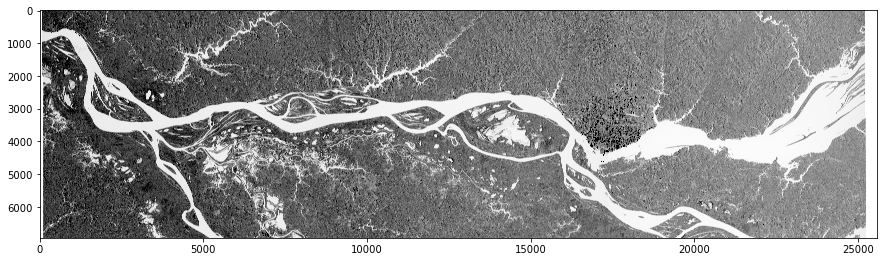

In [7]:
plotBand(S1A_Orb_Sub, 'Intensity_VH', 0, 30000)

In [ ]:
band = S1A_Orb_Sub.getBand('Intensity_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Calibração radiométrica

In [ ]:
# Conversão dos números digitais da imagem em coeficientes de retroespalhamento (Sigma0_VH)

parameters = HashMap()

parameters.put('outputSigmaBand', True) # Definição do tipo de conversão
parameters.put('sourceBands', 'Intensity_VH') # Definição da banda para Intensity_VH
parameters.put('selectedPolarisations', 'VH') # Definição da polarização da banda
parameters.put('outputImageScaleInDb', False) # Resultados em escala linear

S1A_Orb_Sub_Cal = GPF.createProduct('Calibration', parameters, S1A_Orb_Sub) # Geração do produto radiometricamente calibrado

print('Calibração radiométrica: 100%')

Após a calibração radiométrica, a única banda disponível passa a ser a 'Sigma0_VH'.

In [ ]:
band = S1A_Orb_Sub_Cal.getBand('Sigma0_VH')
# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Correção Geométrica

In [ ]:
# Range Doppler Terrain Correction

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')
parameters.put('demName', 'SRTM 3Sec')
parameters.put('demResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('imgResamplingMethod', 'BILINEAR_INTERPOLATION')
parameters.put('pixelSpacingInMeter', 10.0)
parameters.put('mapProjection', 'EPSG:32721')
parameters.put('alignToStandardGrid', 'true')
parameters.put('standardGridOriginX', 0.0)
parameters.put('standardGridOriginY', 0.0)

S1A_Orb_Sub_Cal_Ter = GPF.createProduct('Terrain-Correction', parameters, S1A_Orb_Sub_Cal)

print('Correção Geométrica: 100%')

In [ ]:
listParams('Terrain-Correction')

In [ ]:
band = S1A_Orb_Sub_Cal_Ter.getBand('Sigma0_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Filtragem de ruído speckle

O filtro utilizado será o filtro de Lee, em um kernel de 3x3 pixels.

In [ ]:
# Aplicação do filtro de ruído speckle

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')
parameters.put('filter', 'Lee')
parameters.put('filterSizeX', '3')
parameters.put('filterSizeY', '3')
parameters.put('dampingFactor', '2')
parameters.put('estimateENL', 'true')
parameters.put('enl', '1.0')
parameters.put('numLooksStr', '1')
parameters.put('targetWindowSizeStr', '3x3')
parameters.put('sigmaStr', '0.9')
parameters.put('anSize', '50')

S1A_Orb_Sub_Cal_Ter_Spk = GPF.createProduct('Speckle-Filter', parameters, S1A_Orb_Sub_Cal_Ter)

print('Filtagem do ruído speckle: 100%')

In [ ]:
band = S1A_Orb_Sub_Cal_Ter_Spk.getBand('Sigma0_VH')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Conversão para escala em decibeis

In [ ]:
# LinearToFromdB

parameters = HashMap()

parameters.put('sourceBands', 'Sigma0_VH')

S1A_Orb_Sub_Cal_Ter_Spk_dB = GPF.createProduct('LinearToFromdB', parameters, S1A_Orb_Sub_Cal_Ter_Spk)

print("Conversão para dB: 100%")

In [ ]:
band = S1A_Orb_Sub_Cal_Ter_Spk_dB.getBand('Sigma0_VH_db')

# Getting the width of the scene
width = band.getRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = band.getRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = band.getName()
print('Nome do arquivo: {}'.format(name))

### Salvando a imagem

In [ ]:
ProductIO.writeProduct(S1A_Orb_Sub_Cal_Ter_Spk_Sub_dB, 'C:/Users/jales/Desktop/S1/S1A_2', 'ENVI')

print("Imagem salva com sucesso")

### Importando novamente a imagem

In [ ]:
# Leitura da imagem salva anteriormente

imagem = ProductIO.readProduct('C:/Users/jales/Desktop/S1/S1A_processado/Sigma0_VH_db.hdr')

In [ ]:
# Getting the width of the scene
width = imagem.getSceneRasterWidth()
print('Largura: {} px'.format(width))

# Getting the height of the scene
height = imagem.getSceneRasterHeight()
print('Altura: {} px'.format(height))

# Getting the dataset name
name = imagem.getName()
print('Nome do arquivo: {}'.format(name))

# Getting the band names in the imagery
band_names = imagem.getBandNames()
print('Bandas disponíveis para processamento: {}'.format(', '.join(band_names)))

### Plotando o histograma do produto final

In [ ]:
# Histograma da imagem processada

band = imagem.getBand('Sigma0_VH_db')

w = imagem.getSceneRasterWidth()
h = imagem.getSceneRasterHeight()

band_data = np.zeros(w * h, np.float32)
band.readPixels(0, 0, w, h, band_data)
band_data.shape = h, w

histogram = plt.hist(band_data, bins=2600, range=[-31, -5])

plt.show()

In [ ]:
def thresholding(counts, bins):
    
    x = dict(zip(counts, bins))
    
    max_global = max(x.keys())
    
    dict_max_local = {k:v for (k,v) in x.items() if -40 < v < -17}
    max_local = max(dict_max_local.keys())
    
    dict1_cond = {k:v for (k,v) in x.items() if x[max_global] > v > x[max_local]}
    
    key_threshold = min(dict1_cond.keys())
    
    return x[key_threshold]

In [ ]:
counts = histogram[0]
bins = histogram[1]

thresholding(counts, bins)

In [ ]:
counts

In [ ]:
bins

In [ ]:
x = dict(zip(counts, bins))

In [ ]:
x

In [ ]:
max_global = max(x.keys())

In [ ]:
max_global

In [ ]:
dict_max_local = {k:v for (k,v) in x.items() if -40 < v < -17}

In [ ]:
max_local = max(dict_max_local.keys())

In [ ]:
max_local

In [ ]:
x[max_local]

In [ ]:
dict1_cond = {k:v for (k,v) in x.items() if x[max_global] > v > -25}

In [ ]:
minimo = min(dict1_cond.keys())

In [ ]:
y[minimo]